In [ ]:
import json
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from datasets import Dataset
import torch
import numpy as np


In [ ]:
import json
file_path = "/content/carrière.json"
with open(file_path, 'r') as f:
    data = json.load(f)


In [ ]:
import json
file_path = "/content/tst.json"
with open(file_path, 'r') as f:
    data1 = json.load(f)

In [ ]:
data.extend(data1)

In [ ]:
from collections import Counter
evenement_counts = Counter(
    d["Evenement"].lower() for d in data if "Evenement" in d and isinstance(d["Evenement"], str)
)
sorted_evenement_counts = dict(sorted(evenement_counts.items()))
for evenement, count in sorted_evenement_counts.items():
    print(f"{evenement}: {count}")

avancement d'échelon: 54
avancement de grade: 52
compte rendu d'entretien professionnel: 36
reconstitution de carrière: 50
tableau annuel avancement de grade: 38


In [ ]:
data_full=data1

In [ ]:
import random
from collections import defaultdict
for d in data_full:
    if d.get('Evenement'):
        d['Evenement'] = d['Evenement'].strip().lower()
missing_new_act = [item for item in data_full if not item.get('Evenement')]
print(f"🚫 Skipped due to missing or empty 'new_act': {len(missing_new_act)}")
grouped = defaultdict(list)
for item in data_full:
    act = item.get('Evenement')
    if act:
        grouped[act].append(item)

final_sample = []
leftovers = []
for act, items in grouped.items():
    count = len(items)

    if count < 20:
        print(f"⚠️ Warning: Only {count} items found for new_act = '{act}' (less than 20)")

    random.shuffle(items)
    selected = items[:min(count, 80)]
    remaining = items[min(count, 80):]

    final_sample.extend(selected)
    leftovers.extend(remaining)
print(f"\n✅ Total selected samples: {len(final_sample)}")
print(f"🧾 Remaining (not selected) samples: {len(leftovers)}")
print(f"📦 Original full data count: {len(data_full)}")
print(f"🔁 Combined sample + leftover: {len(final_sample) + len(leftovers)}")
print(f"📂 Missing 'new_act' (logged separately): {len(missing_new_act)}")
print("\n🔎 Sample of entries missing 'new_act':")
for i, entry in enumerate(missing_new_act[:5], 1):
    print(f"\n--- Missing Entry #{i} ---")
    for key, value in entry.items():
        print(f"{key}: {value}")


🚫 Skipped due to missing or empty 'new_act': 0

✅ Total selected samples: 284
🧾 Remaining (not selected) samples: 2115
📦 Original full data count: 2399
🔁 Combined sample + leftover: 2399
📂 Missing 'new_act' (logged separately): 0

🔎 Sample of entries missing 'new_act':


In [ ]:
len(final_sample)

284

In [ ]:
import numpy as np
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report # Make sure this is imported for section 11
)
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)


texts = [d['input'] for d in final_sample]
labels = [d['Evenement'] for d in final_sample]

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

# --- 1. Model and Tokenizer Definition ---
model_name = "maastrichtlawtech/legal-camembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    ignore_mismatched_sizes=True
)

# --- 2. Tokenization Function ---
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding=False,
        max_length=512,
        return_tensors=None
    )

# --- 3. Create Datasets ---
train_dataset = Dataset.from_dict({"text": X_train, "labels": y_train})
test_dataset = Dataset.from_dict({"text": X_test, "labels": y_test})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# --- 4. Data Collator ---
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# --- 5. Compute Metrics Function ---
def compute_metrics_multiclass(eval_pred):
    logits, labels = eval_pred
    predictions_ids = np.argmax(logits, axis=-1)
    probs = torch.nn.functional.softmax(torch.Tensor(logits).float(), dim=-1).numpy()

    acc = accuracy_score(labels, predictions_ids)
    f1_micro = f1_score(labels, predictions_ids, average='micro', zero_division=0)
    f1_macro = f1_score(labels, predictions_ids, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, predictions_ids, average='weighted', zero_division=0)

    roc_auc_macro = 0.0
    roc_auc_weighted = 0.0
    try:
        if len(np.unique(labels)) > 1:
            if probs.shape[1] == len(label_encoder.classes_):
                roc_auc_macro = roc_auc_score(labels, probs, average='macro', multi_class='ovr')
                roc_auc_weighted = roc_auc_score(labels, probs, average='weighted', multi_class='ovr')
            else:
                print(f"Warning: ROC AUC. Probs shape ({probs.shape[1]}) vs num_classes ({len(label_encoder.classes_)}).")
        else:
            print("Warning: Only one class in y_true batch. ROC AUC not defined, set to 0.")
    except ValueError as e:
        print(f"Could not compute ROC AUC: {e}. Setting to 0.")

    return {
        "accuracy": acc,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "roc_auc_macro": roc_auc_macro,
        "roc_auc_weighted": roc_auc_weighted,
    }

# --- 6. Weighted Loss Function Setup ---
unique_labels_in_train = np.unique(y_train)
# The check below is good practice
if not np.all(np.isin(unique_labels_in_train, np.arange(len(label_encoder.classes_)))):
    raise ValueError("y_train contains labels not seen by the label_encoder or not in sequential order from 0.")

class_weights_array = compute_class_weight(
    'balanced',
    classes=unique_labels_in_train,
    y=y_train
)
calculated_class_weights = np.zeros(len(label_encoder.classes_)) # Renamed to avoid conflict
for i, label_val in enumerate(unique_labels_in_train):
    calculated_class_weights[label_val] = class_weights_array[i]

class_weights_tensor = torch.tensor(calculated_class_weights, dtype=torch.float)


class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.custom_class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # Added **kwargs to accept extra arguments
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.custom_class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.custom_class_weights.to(logits.device))
        else:
            print("Warning: CustomTrainer initialized without class_weights, using unweighted loss.")
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- 7. Training Arguments ---
training_args = TrainingArguments(
    output_dir="./results_multilabel_improved",
    num_train_epochs=20,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    weight_decay=0.001,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",

    warmup_ratio=0.1,
    logging_dir="./logs_multilabel_improved",
    logging_strategy="steps",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    report_to="wandb", # Optional
    # seed=42,
)

# --- 8. Trainer Definition ---
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_multiclass,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    class_weights=class_weights_tensor # Pass the calculated weights here
)

# --- 9. Train the Model ---
print("Starting training...")
trainer.train()
print("Training finished.")

# --- 10. Evaluate the Best Model ---
print("Evaluating the best model on the test set...")
eval_results = trainer.evaluate(eval_dataset=test_dataset) # Pass test_dataset explicitly
print("Evaluation results:", eval_results)


print("\nGenerating detailed classification report...")
predictions_output = trainer.predict(test_dataset) 
predicted_labels_ids = np.argmax(predictions_output.predictions, axis=1)
true_labels_ids = predictions_output.label_ids

predicted_labels_str = label_encoder.inverse_transform(predicted_labels_ids)
true_labels_str = label_encoder.inverse_transform(true_labels_ids)
target_names = label_encoder.classes_

try:
    report = classification_report(
        true_labels_str,
        predicted_labels_str,
        target_names=target_names,
        digits=3,
        zero_division=0
    )
    print("\nClassification Report:")
    print(report)
except ValueError as e:
    print(f"\nError generating classification report: {e}")
    print("True unique labels:", np.unique(true_labels_str))
    print("Predicted unique labels:", np.unique(predicted_labels_str))
model_type="contract"

best_model_path =f"./results_{model_type}/best_model"
print(f"\nSaving the best model to {best_model_path}...")
trainer.save_model(best_model_path)
tokenizer.save_pretrained(best_model_path)
print("Model and tokenizer saved.")

print("\nScript finished successfully.")

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at maastrichtlawtech/legal-camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

<ipython-input-45-2896132379>:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,F1 Weighted,Roc Auc Macro,Roc Auc Weighted
50,1.494300,1.250847,0.666667,0.666667,0.668398,0.573783,0.966463,0.952931
100,0.829300,0.381129,0.982456,0.982456,0.987488,0.982439,0.999695,0.999572
150,0.204400,0.105184,0.964912,0.964912,0.975000,0.964912,0.999390,0.999144
200,0.062400,0.040496,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
250,0.033200,0.025640,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
300,0.023400,0.021506,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
350,0.018100,0.017803,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Training finished.
Evaluating the best model on the test set...


Evaluation results: {'eval_loss': 0.040495630353689194, 'eval_accuracy': 1.0, 'eval_f1_micro': 1.0, 'eval_f1_macro': 1.0, 'eval_f1_weighted': 1.0, 'eval_roc_auc_macro': 1.0, 'eval_roc_auc_weighted': 1.0, 'eval_runtime': 0.6676, 'eval_samples_per_second': 85.386, 'eval_steps_per_second': 5.992, 'epoch': 12.070175438596491}

Generating detailed classification report...

Classification Report:
                                        precision    recall  f1-score   support

                  avancement d'échelon      1.000     1.000     1.000        16
                   avancement de grade      1.000     1.000     1.000        16
compte rendu d'entretien professionnel      1.000     1.000     1.000         7
            reconstitution de carrière      1.000     1.000     1.000        10
    tableau annuel avancement de grade      1.000     1.000     1.000         8

                              accuracy                          1.000        57
                             macro avg      

In [ ]:
model_type="carrière"

best_model_path =f"./results_{model_type}/best_model"

In [ ]:
import pickle

In [ ]:

label_encoder_path = f"{best_model_path}/label_encoder.pkl" # Use .pkl extension by convention
print(f"Saving the label encoder to {label_encoder_path}...")
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)

Saving the label encoder to ./results_contract/best_model/label_encoder.pkl...


In [ ]:
import zipfile
import os

def zip_folder(folder_path, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                full_path = os.path.join(root, file)
                relative_path = os.path.relpath(full_path, folder_path)
                zipf.write(full_path, arcname=relative_path)
                print(f'Added {relative_path}')
import zipfile
import os
import shutil
def move_zip(zip_path, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    destination_path = os.path.join(destination_folder, os.path.basename(zip_path))
    shutil.move(zip_path, destination_path)
    print(f'ZIP déplacé vers: {destination_path}')


Added sentencepiece.bpe.model
Added label_encoder.pkl
Added special_tokens_map.json
Added model.safetensors
Added tokenizer_config.json
Added config.json
Added tokenizer.json
Added training_args.bin
ZIP déplacé vers: /content/drive/Shareddrives/Projets/CDG71/data/data v _2025-06-12/reclassement/fine_tuned_reclassement.zip


In [ ]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle
import torch
from sklearn.metrics import classification_report

def load_trained_model(model_path=best_model_path):
    """Load the fine-tuned model, tokenizer, and label encoder"""
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    with open(f"{model_path}/label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    print(f"Model loaded on {device}")
    print(f"Classes: {list(label_encoder.classes_)}")
    return model, tokenizer, label_encoder

def predict_with_loaded_model(text, model, tokenizer, label_encoder):
    """Make prediction with loaded model"""
    device = next(model.parameters()).device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class_id = predictions.argmax().item()
        confidence = predictions.max().item()
    predicted_label = label_encoder.inverse_transform([predicted_class_id])[0]
    return predicted_label, confidence



In [ ]:
def test_model_on_leftover_list_with_correctness(model, tokenizer, label_encoder, test_data):

    results = []
    from tqdm.auto import tqdm

    for item in tqdm(test_data, desc="Predicting on test data"):
        text = item["input"]
        true_label = item["Evenement"]

        predicted_label, confidence = predict_with_loaded_model(
            text, model, tokenizer, label_encoder
        )

        # --- THIS IS THE NEW PART ---
        is_correct = (true_label == predicted_label)
        # --- END OF NEW PART ---

        results.append({
            "text": text,
            "true_label": true_label,
            "predicted_label": predicted_label,
            "confidence": confidence,
            "is_correct": is_correct # Add the new value to the dictionary
        })
    return results

In [ ]:

print("Running model on the test data...")
model, tokenizer, label_encoder = load_trained_model()
all_results = test_model_on_leftover_list_with_correctness(model, tokenizer, label_encoder, data)

print("Converting results to a DataFrame...")
df_all_results = pd.DataFrame(all_results)

df_all_results = df_all_results[[
    "text",
    "true_label",
    "predicted_label",
    "is_correct", 
    "confidence"
]]


output_filename = "full_prediction_analysis.xlsx"
print(f"Exporting all results to {output_filename}...")

df_all_results.to_excel(output_filename, index=False)

print("Export complete.")

Running model on the test data...
Model loaded on cuda
Classes: [np.str_("avancement d'échelon"), np.str_('avancement de grade'), np.str_("compte rendu d'entretien professionnel"), np.str_('reconstitution de carrière'), np.str_('tableau annuel avancement de grade')]


Predicting on test data:   0%|          | 0/230 [00:00<?, ?it/s]

Converting results to a DataFrame...
Exporting all results to full_prediction_analysis.xlsx...
Export complete.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle
import torch
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


PERFORMANCE EVALUATION

--- Classification Report ---

                                        precision    recall  f1-score   support

                  avancement d'échelon       1.00      0.98      0.99      1932
                   avancement de grade       0.95      0.99      0.97       343
compte rendu d'entretien professionnel       0.95      1.00      0.97        36
            reconstitution de carrière       0.68      1.00      0.81        50
    tableau annuel avancement de grade       1.00      1.00      1.00        38

                              accuracy                           0.98      2399
                             macro avg       0.91      0.99      0.95      2399
                          weighted avg       0.98      0.98      0.98      2399


--- Generating Confusion Matrix ---



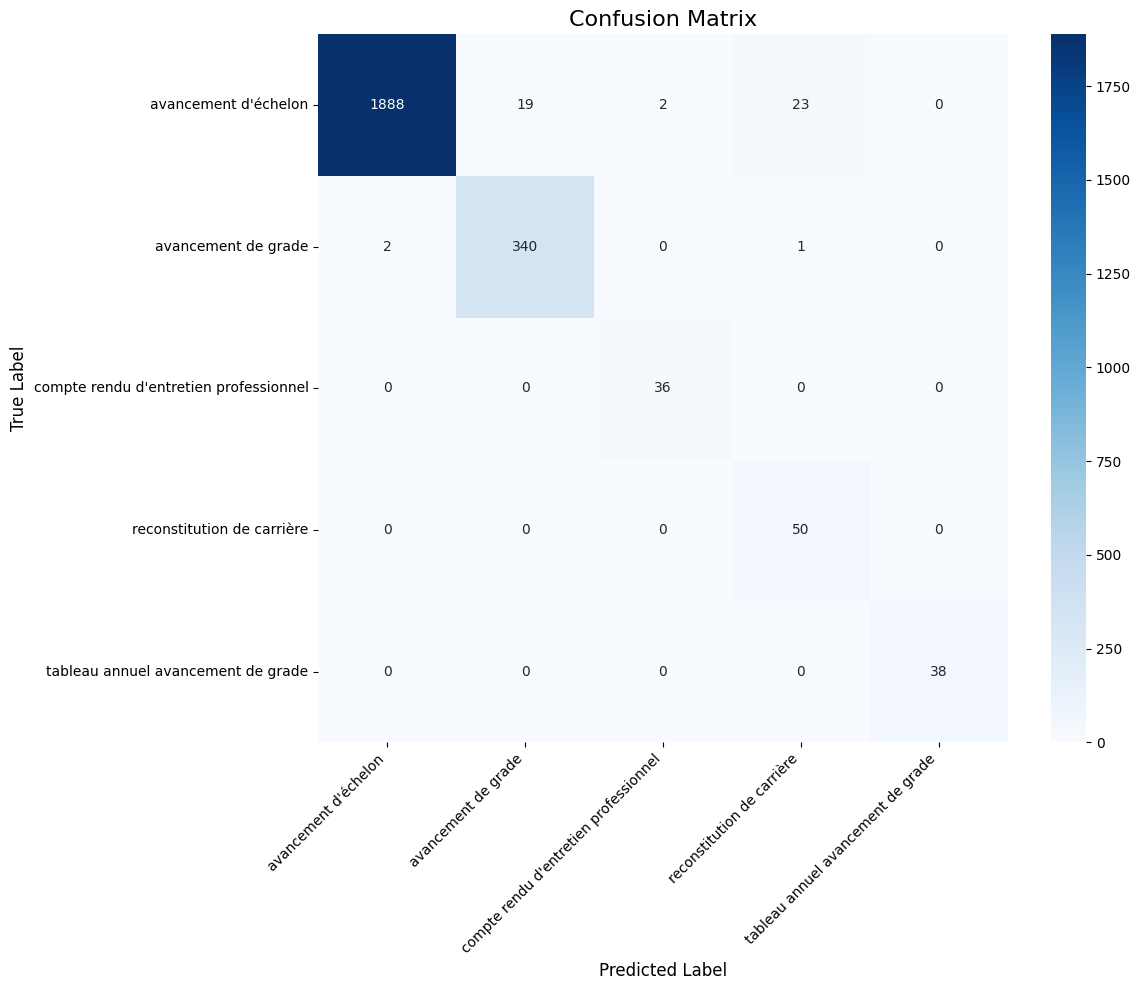

Evaluation complete.


In [ ]:
print("\n" + "="*50)
print("PERFORMANCE EVALUATION")
print("="*50)

y_true = df_all_results['true_label']
y_pred = df_all_results['predicted_label']

class_names = label_encoder.classes_

print("\n--- Classification Report ---\n")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

print("\n--- Generating Confusion Matrix ---\n")
cm = confusion_matrix(y_true, y_pred, labels=class_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Evaluation complete.")

In [ ]:
len(df_all_results[df_all_results['is_correct'] == False])

47

In [ ]:
output_file_path = 'tst.json'

# Read the JSON data from file
with open(output_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

In [ ]:
def test_model_on_leftover_list_with_correctness(model, tokenizer, label_encoder, test_data):

    results = []
    from tqdm.auto import tqdm

    for item in tqdm(test_data, desc="Predicting on test data"):
        text = item["input"]
        true_label = item["Evenement"]

        predicted_label, confidence = predict_with_loaded_model(
            text, model, tokenizer, label_encoder
        )

  
        is_correct = (true_label.lower().strip() == predicted_label.lower().strip())


        results.append({
            "text": text,
            "true_label": true_label,
            "predicted_label": predicted_label,
            "confidence": confidence,
            "is_correct": is_correct
        })
    return results

In [ ]:

print("Running model on the test data...")
model, tokenizer, label_encoder = load_trained_model()
all_results = test_model_on_leftover_list_with_correctness(model, tokenizer, label_encoder, data)

print("Converting results to a DataFrame...")
df_all_results = pd.DataFrame(all_results)

df_all_results = df_all_results[[
    "text",
    "true_label",
    "predicted_label",
    "is_correct",
    "confidence"
]]

output_filename = "full_prediction_analysis.xlsx"
print(f"Exporting all results to {output_filename}...")

df_all_results.to_excel(output_filename, index=False)

print("Export complete.")

Running model on the test data...
Model loaded on cuda
Classes: [np.str_("avancement d'échelon"), np.str_('avancement de grade'), np.str_("compte rendu d'entretien professionnel"), np.str_('reconstitution de carrière'), np.str_('tableau annuel avancement de grade')]


Predicting on test data:   0%|          | 0/2170 [00:00<?, ?it/s]

Converting results to a DataFrame...
Exporting all results to full_prediction_analysis.xlsx...
Export complete.
